<center style="font-size:30px;padding-bottom:10px;color:DarkBlue;">Procesos Estocásticos</center>
<center> _____________________________________________________________________________________________ </center>
<p>&nbsp;</p>
<center style="font-size:25px;padding-bottom:10px;color:CornFlowerBlue;">Sistemas en Tiempo Discreto</center>
<center style="font-size:20px;padding-bottom:10px;color:LightCoral;">Ejercicios Finales</center>
<center style="font-size:15px;">Gloria del Valle Cano</center>
<center style="font-size:12px;">13 de diciembre 2021</center>



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import uniform
from tqdm import tqdm
from kalman_aux import *
from sklearn.linear_model import LinearRegression
from IPython.display import display, Math, Latex

# Ejercicio I
**Enunciado**. En los apuntes hay un ejemplo del *Gambler's Ruin* como cadena de Markov. Hacer un gráfico del número medio de jugadas que el jugador puede hacer antes de arruinarse en función del dinero inicial. En cada jugada se juega 1 Euro, y el juego es ecuo (el jugador tiene una probabilidad 1/2 de ganar).
Estimar media y varianza (usar unas 20 ejecuciones. . . deberían ser más que suficientes) considerando un dinero inicial de 1, . . . , 50 Euros. Indicar media y varianza. ¿Cómo varían la media y la varianza cuando aumenta el dinero inicial? Dar una estimación de la función T(ϵ) que da el tiempo medio necesario para arruinarse en función de la cantidad inicial de dinero, ϵ. Según esta función, ¿cuánto tarda el jugador en
arruinarse si empieza a jugar con 200 Euros?

**Solución**. Es preciso destacar que, como hemos visto en la teoría, la probabilidad de arruinarse es siempre 1. Rescatando de los apuntes, tenemos que estimar $k_m := \mathbb{E}_m(H^0 | m; 0)$ para $m≥0$, siendo $m$ el capital inicial. Asimismo, es viable calcular estos valores como soluciones minimales no negativas del sistema:

$$
\begin{cases} k_0 = 0 \\ k_m = 1 + \frac 1 2 k_{m-1} + \frac 1 2 k_{m+1}, & \;\;\;m ≥ 1. \end{cases}
$$

Resolviendo el sistema se llega a la siguiente solución:

$$
k_m = mA - m^2 + m, \;\;\; m≥0
$$

Sabiendo que $k_m≥0$ para todo $m$, $A=\infty$, por lo que también $k_m=\infty$ para todo $m≥1$.

Para la implementación de este ejercicio se ha implementado la clase ```GamblersRuin```, el cual simula la ruina del apostador como cadena de Markov, la cual se muestra a continuación. 

In [2]:
class GamblersRuin:
    
    def __init__(self, p, k):
        """
        Init function for Gambler's Ruin simulation.
        Args:
            p (float): probability of winning a round.
            k (int): gamblers wealth.
        """
        self.p = p    # p
        self.k = k    # wealth
        self.c = 0    # counter
        
    def update_wealth(self):
        """
        Computes every step for simulation
        """
        if self.k == 0:
            return 0
        else:
            self.c += 1
            self.k += 2*int(uniform(0,1) < self.p) - 1
        return self.k

A continuación se muestran las funciones creadas para la simulación, el tiempo medio y la varianza del tiempo hasta la ruina.

In [3]:
def gr_simulate(n, limit, p):
    times = np.zeros((limit, n))
    for k in tqdm(range(1, limit)):
        for ex in range(n):
            gr = GamblersRuin(p, k+1)
            while gr.update_wealth() and gr.c < 1e5:
                pass
            times[k][ex] = gr.c
    return times

def gr_plot_median(limit, times):
    plt.figure(figsize=(18, 6))
    plt.plot(np.arange(limit), np.median(times, axis=1), color="b", marker='o')
    plt.xlabel(f'Initial wealth')
    plt.ylabel(f'Median gambles till ruin')
    plt.title(f'Median')
    
def gr_plot_mean_var(limit, times):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    ax[0].set_xlabel(f'Initial wealth')
    ax[1].set_xlabel(f'Initial wealth')
    ax[0].set_title(f'Mean')
    ax[1].set_title(f'Variance')
    ax[0].set_ylabel(f'Average till ruin')
    ax[1].set_ylabel(f'Variance till ruin')
    ax[0].plot(np.arange(limit), np.mean(times, axis=1), color="g", marker='o')
    ax[1].plot(np.arange(limit), np.var(times, axis=1), color="b", marker='o')
    fig.suptitle("Mean and variance analysis")

Realizamos 20 simulaciones para una riqueza inicial de $1 ... 50$ euros.

In [4]:
n = 20
limit = 51
p = 0.5
times = gr_simulate(n, limit, p)

100%|██████████| 50/50 [00:09<00:00,  5.42it/s]


A priori, esperamos que el cálculo del número medio de apuestas que el jugador puede realizar en función de su riqueza antes de arruinarse va a tener mucha varianza, por lo que la representación va a dar lugar a picos muy altos. Es por ello que se decide además mostrar la mediana además, con el fin de visualizar mejor el comportamiento del problema.

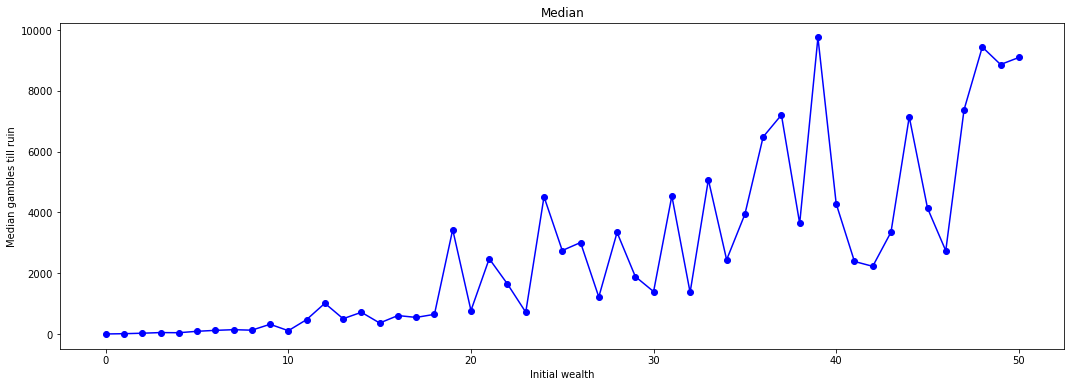

In [5]:
gr_plot_median(limit, times)

Finalmente se representan los resultados obtenidos tanto para la media como para la varianza. Vemos como siguen un patrón creciente, además de poderse interpretar como más o menos lineal.

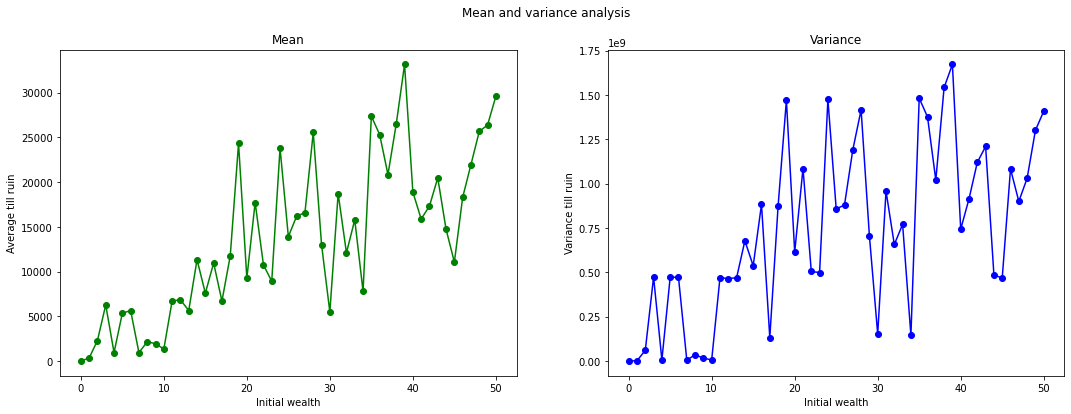

In [6]:
gr_plot_mean_var(limit, times)

Para poder estimar $T(e)$ utilizamos una regresión lineal, apoyándonos en que el problema parece poder tratarse como tal. Simulamos el problema para una riqueza de $200$ euros.

In [7]:
limit = 201
times = gr_simulate(n, limit, p)

100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


Obtenemos la aproximación mediante regresión lineal.

In [8]:
def gr_te(limit, times):
    x = np.arange(limit)
    lr = LinearRegression().fit(x.reshape(-1, 1), np.mean(times, axis=1))
    T = lambda i: np.round(lr.predict(np.array([i]).reshape(-1, 1)))
    return x, T

def gr_plot_te(x, times, T):
    plt.figure(figsize=(18, 6))
    plt.plot(T(x), color='magenta')
    plt.scatter(x, np.mean(times, axis=1), color='b')
    plt.xlabel(f'Initial wealth')
    plt.ylabel(f'Mean gambles till ruin')
    plt.title(f'Mean time till ruin')
    plt.show()

Mostramos los resultados de la regresión.

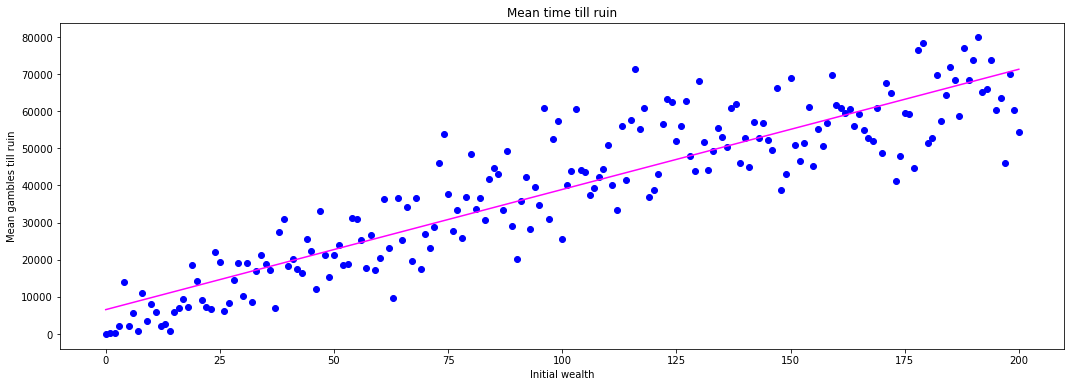

In [9]:
x, T = gr_te(limit, times)
gr_plot_te(x, times, T)

Se obtiene que para $e=200$ la ruina se alcanza en $71856$ pasos.

In [10]:
int(T(200)[0])

71312

Si lo llevamos a la vida real, esto no sería viable ya que los jugadores tendrían que jugar como unos $80000$ turnos, por lo que podríamos concluir con que nunca llegarían a arruinarse.

# Ejercicio II
**Enunciado**.

**a)** Crear cuatro sistemas dinámicos del tipo
$$
\begin{align*}
  x_{t+1}&=Ax_t + Bu_t + w_t,\\
  z_t &=Cx_t + v_t,
\end{align*}
$$

con $x_t \in \mathbb{R}^4$, $u_t \in \mathbb{R}$, $z_t \in \mathbb{R}^2$, y

$$
  \mathbb{B} =
  \begin{pmatrix}
    1 & 1 & 1 & 1
  \end{pmatrix}',
$$

$$
  \mathbb{C} =
  \begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0
  \end{pmatrix}.
$$

Los sistemas se distinguen por la matriz $A$, que es, por cada sistema una de las cuatro matrices generadas usando la función $\texttt{mk\_mat}$ (en el fichero $\texttt{kalman\_aux.py}$) a partir de las siguientes listas de autovalores:

$$
\Lambda_1 = [0.2, 0.1, 0., -0.1] \\
\Lambda_2 = [0.99, 0.1, 0., -0.1] \\
\Lambda_3 = [1., 0.1, 0., -0.1] \\
\Lambda_4= [0.2, 0.1, 0., -1.]
$$

Los ruidos $w_t \in \mathbb{R}^4$ y $v_t \in \mathbb{R}^2$ son gaussianos y tienen matrices de covarianza

$$
Q = \sigma_w^2 \mathbb{I}_4 \\
R = \sigma_v^2 \mathbb{I}_2
$$

donde $\mathbb{I}_n$ es la matriz identidad de orden $n$.

El fichero $\texttt{kalman\_aux.py}$ define las matrices $\mathbb{B}$, $\mathbb{C}$, $\mathbb{Q}$ y $\mathbb{R}$, y proporciona la función $\texttt{mk\_mat}$ para crear la matriz $\mathbb{A}$ dada la lista de autovalores. (La matriz $\mathbb{A}$ tiene autovectores generados aleatoriamente, por tanto cada llamada a la función con los mismos autovalores generará matrices diferentes que tienen esos autovalores).

**b)** Por cada uno de los sistemas generados, crear un filtro de Kalman para estimar el estado de este sistema utilizando como función de input la función

$$
u(t) = \begin{cases} 0 \;\;\; t≤50 \\ 1 \;\;\; t > 50\end{cases}
$$

(el fichero también contiene una función auxiliar $\texttt{u\_f(t)}$ que define la función).

Realizar la simulación con $t = 0, ..., 99$ y dibujar una gráfica del error relativo

$$
e(t)=\sum_{k=1}^t\frac{||\hat x_{t,k} - x_{t,k}||^2}{||x_t||^2}
$$

**c)** Discutir cómo los autovalores afectan al error.

**Solución**.

Para poder computar de manera unificada se crea la clase ```KalmanFilter``` sobre la cual se crea el sistema dinámico planteado. Además la clase define la recursión del filtro y permite realizar $n$ experimentos de $t$ ejecuciones, sobre los cuales se calculan los errores correspondientes.


*Consideraciones de la implementación*

* La estimación inicial de $x_t$ se ha tomado como 0, por lo que $P$ podemos tomarla también inicializada a 0. Como no se conocen los estados anteriores, para las primeras iteraciones no se van a obtener buenas estimaciones, pero se espera que tras ello el sistema será mas estable.


In [2]:
class KalmanFilter:
    
    def __init__(self, A, B, C, Q, R, n, times):
        """
        Init function for Kalman Filter
        """
        self.A = A                                                                                      # A, hidden process for state matrix
        self.B = B                                                                                      # B, hidden process for state matrix
        self.C = C                                                                                      # C, observable process for state matrix

        self.Q = Q                                                                                      # Q, covariance matrix related to w_t (defined in kalman_aux.py)
        self.R = R                                                                                      # R, covariance matrix related to v_t (defined in kalman_aux.py)

        self.times = times                                                                              # save times for simulation
        self.P = np.zeros((4,4))                                                                        # P, process covariance matrix initial estimation
        
        self.z_t = np.zeros((2,))                                                                       # init observation process
        self.x_t = np.zeros((4,))                                                                       # uniform initial
        
        self.u_t = np.array([u_f(i) for i in range(times)])                                             # input function
        
        self.w_t = np.random.normal(mu, sigma, (100, 4))                                                # gaussian noise R^2
        self.v_t = np.random.normal(mu, sigma, (100, 2))                                                # gaussian noise R^4
        
        self.n = n                                                                                      # number of experiments
        self.e_t = []                                                                 # init relative error
        self.K_t = np.zeros((A.shape[0], C.shape[0]))                                                   # init K Gain

    def kf_system(self, t):
        """
        Computes dynamic system defined by
            x_{t+1} = Ax_t + w_t
                z_t = Cx_t + v_t
        """
        self.x_t = self.A @ self.x_t + self.B * self.u_t[t] + self.w_t[t]                               # update states
        self.z_t = self.C @ self.x_t + self.v_t[t]                                                      # update observation process
        
    def kf_gain(self, P_bar):
        """
        Computes the Kalman Gain given by
            K_t(C \bar P_t C' + R) = \bar P_t C'
        """
        self.K_t = P_bar @ self.C.T @ np.linalg.inv(self.C @ P_bar @ self.C.T + self.R)                 # update kalman gain

    def kf_update_matrix(self, x_bar, P_bar):
        """
        Updates the estimate and the covariance
        """
        x_hat = x_bar + self.K_t @ (self.z_t - self.C @ x_bar)                                          # update the estimate
        P_t = (np.identity(self.C.shape[1]) - self.K_t @ self.C) @ P_bar                                # update the covariance

        return x_hat, P_t

    def kf_compute_priors(self, x_hat, P_t, t):
        """
        Computes the priors (predict)
        """
        x_bar = self.A @ x_hat + self.B * self.u_t[t]                                                   # compute the priors (state matrix)
        P_bar = self.A @ P_t @ self.A.T + self.Q                                                        # compute the priors (process covariance matrix)

        return x_bar, P_bar

    def kf_relative_error(self, abs, err):
        """
        Computes relative error
        """
        rel_err = abs / err                                                                             # relative error
        self.e_t.append(rel_err)                                                                        # save error

    def kf_run(self):
        """
        KF simulation for n experiments and t times
            1) create dinamic system
            2) compute kalman gain
            3) update
                3.1) update estimate
                3.2) update covariance
            4) predict
                4.1) prior for estimate
                4.2) prior for covariance
        and then computes relative error, mean error and std
        """

        # n experiments
        for i in range(self.n):

            # initial values
            x_bar = self.x_t
            P_bar = self.P
            abs = np.array([])
            err = np.array([])

            # simulation times = 0,...,99
            for t in range(self.times):

                # recursive filter
                self.kf_system(t)
                self.kf_gain(P_bar)
                x_hat, P_t = self.kf_update_matrix(x_bar, P_bar)
                x_bar, P_bar = self.kf_compute_priors(x_hat, P_t, t)

                # relative error
                abs = np.append(abs, np.trace(P_t))
                err = np.append(err, np.linalg.norm(self.x_t))

            # update relative error    
            self.kf_relative_error(abs, err)

        return self.e_t

**a)** El sistema dinámico lo hemos definido gracias al constructor de la clase y los parámetros siguientes de entrada.

**b)** El filtro se ha creado teniendo en cuenta los siguientes pasos:

1. Creación del sistema dinámico

2. Cómputo de la ganancia: $K_t = \bar P_t C' (C \bar P_t C' + R)^{-1}$

3. Actualización de $x$ y $P$

    3.1. Actualización del estimador: $\hat x_t = \bar x_t + K_t(z_t - C\bar x_t)$  
    
    3.2. Actualización de la covarianza: $P_t = (\mathbb{I} - K_tC)\bar P_t$

4. Predicción

    4.1. Prior para la estimación: $\bar x_{t+1} = A \hat x_t + B u_t$

    4.2. Prior para la covarianza: $\bar P_{t+1} = A P_t A' + Q$

**c)** A continuación se muestran los resultados de los errores de la simulación

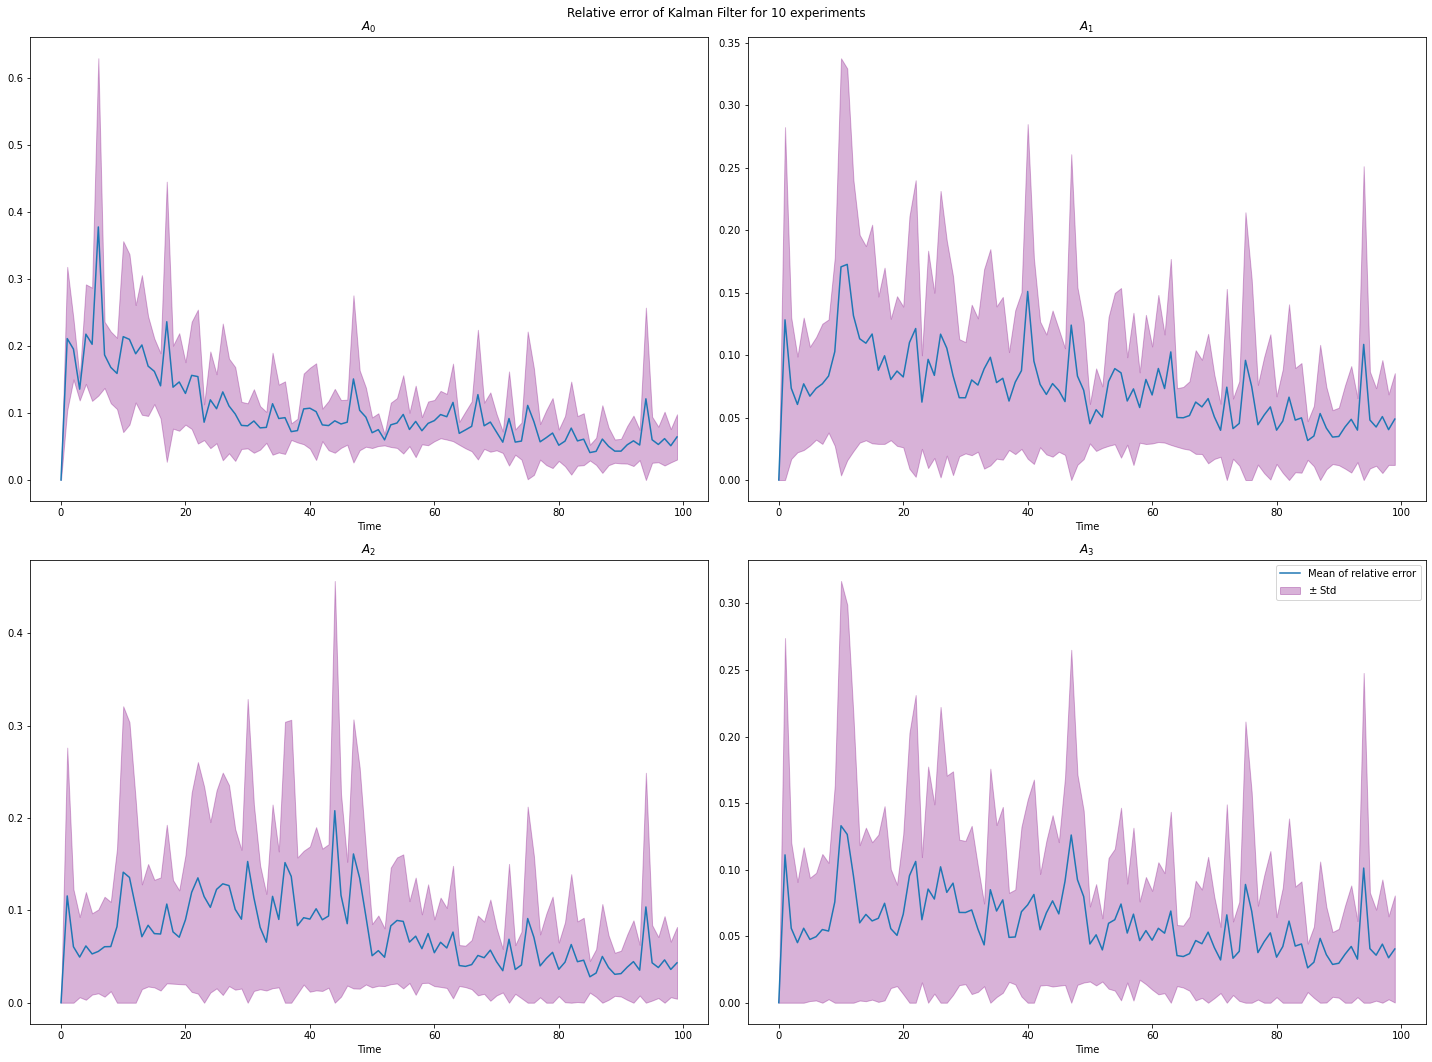

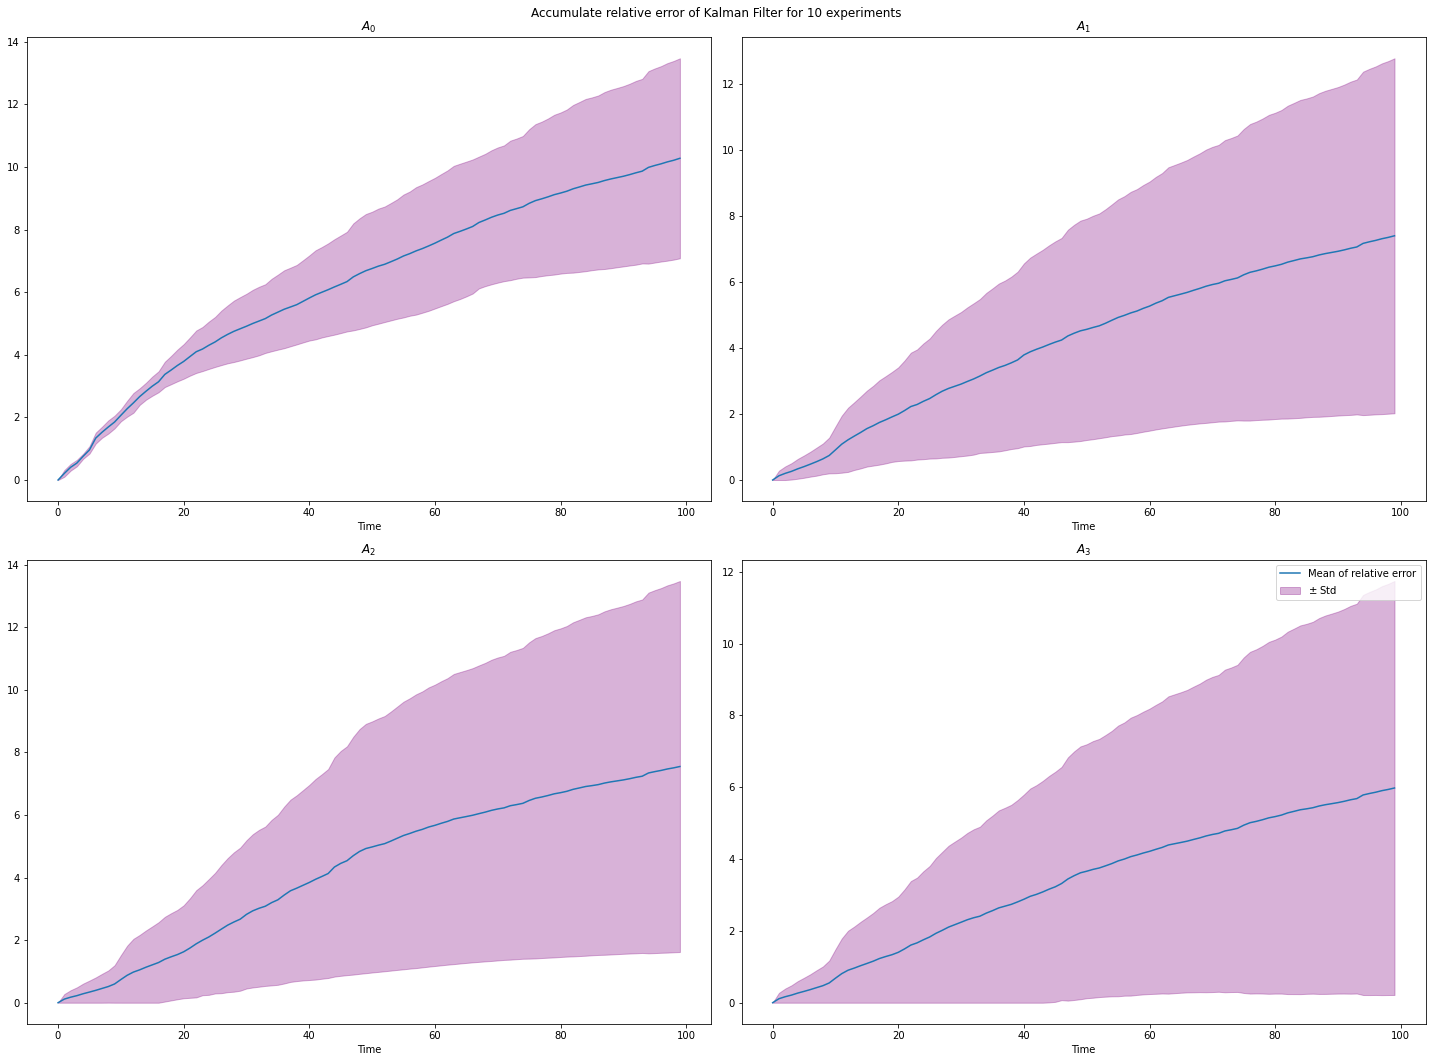

In [3]:
a_1 = [0.2, 0.1, 0., -0.1]
a_2 = [0.99, 0.1, 0., -0.1]
a_3 = [1., 0.1, 0., -0.1]
a_4 = [0.2, 0.1, 0., -1.]
a_values = [a_1, a_2, a_3, a_4]

B = np.ones(4).T
C = np.array([[1., 0., 0., 0.],
              [0., 1., 0., 0.]])

n = 10
times = 100
mu, sigma = 0., 1.

all_err, all_acc = [], []
for matrix in a_values:
    A = np.array(mk_mat(matrix))
    mean_err = KalmanFilter(A, B, C, Q, R, n, times).kf_run()
    all_err.append(mean_err)
    all_acc.append(np.cumsum(mean_err, axis=1))

means = np.mean(all_err, axis=0)
stds = np.std(all_err, axis=0)

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle(f'Relative error of Kalman Filter for {n} experiments')
ax = np.array(ax).flatten()
for i in range(4):
    ax[i].plot(np.arange(times), means[i], label=f"Mean of relative error")
    ax[i].fill_between(np.arange(times), np.maximum(means[i] - stds[i],0), means[i] + stds[i], color = 'purple', alpha = 0.3, label = r"$\pm$ Std")
    ax[i].set_title(f'$A_{i}$')
    ax[i].set_xlabel("Time")
fig.tight_layout()
plt.legend()
plt.show()

means_c = np.mean(all_acc, axis=0)
stds_c = np.std(all_acc, axis=0)

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle(f'Accumulate relative error of Kalman Filter for {n} experiments')
ax = np.array(ax).flatten()
for i in range(4):
    ax[i].plot(np.arange(times), means_c[i], label=f"Mean of relative error")
    ax[i].fill_between(np.arange(times), np.maximum(means_c[i] - stds_c[i], 0), means_c[i] + stds_c[i], color = 'purple', alpha = 0.3, label = r"$\pm$ Std")
    ax[i].set_title(f'$A_{i}$')
    ax[i].set_xlabel("Time")
fig.tight_layout()
plt.legend()
plt.show()